<a href="https://colab.research.google.com/github/parseny/Generative-Models-2024/blob/main/Assignment%202/2_tricks_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2024, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

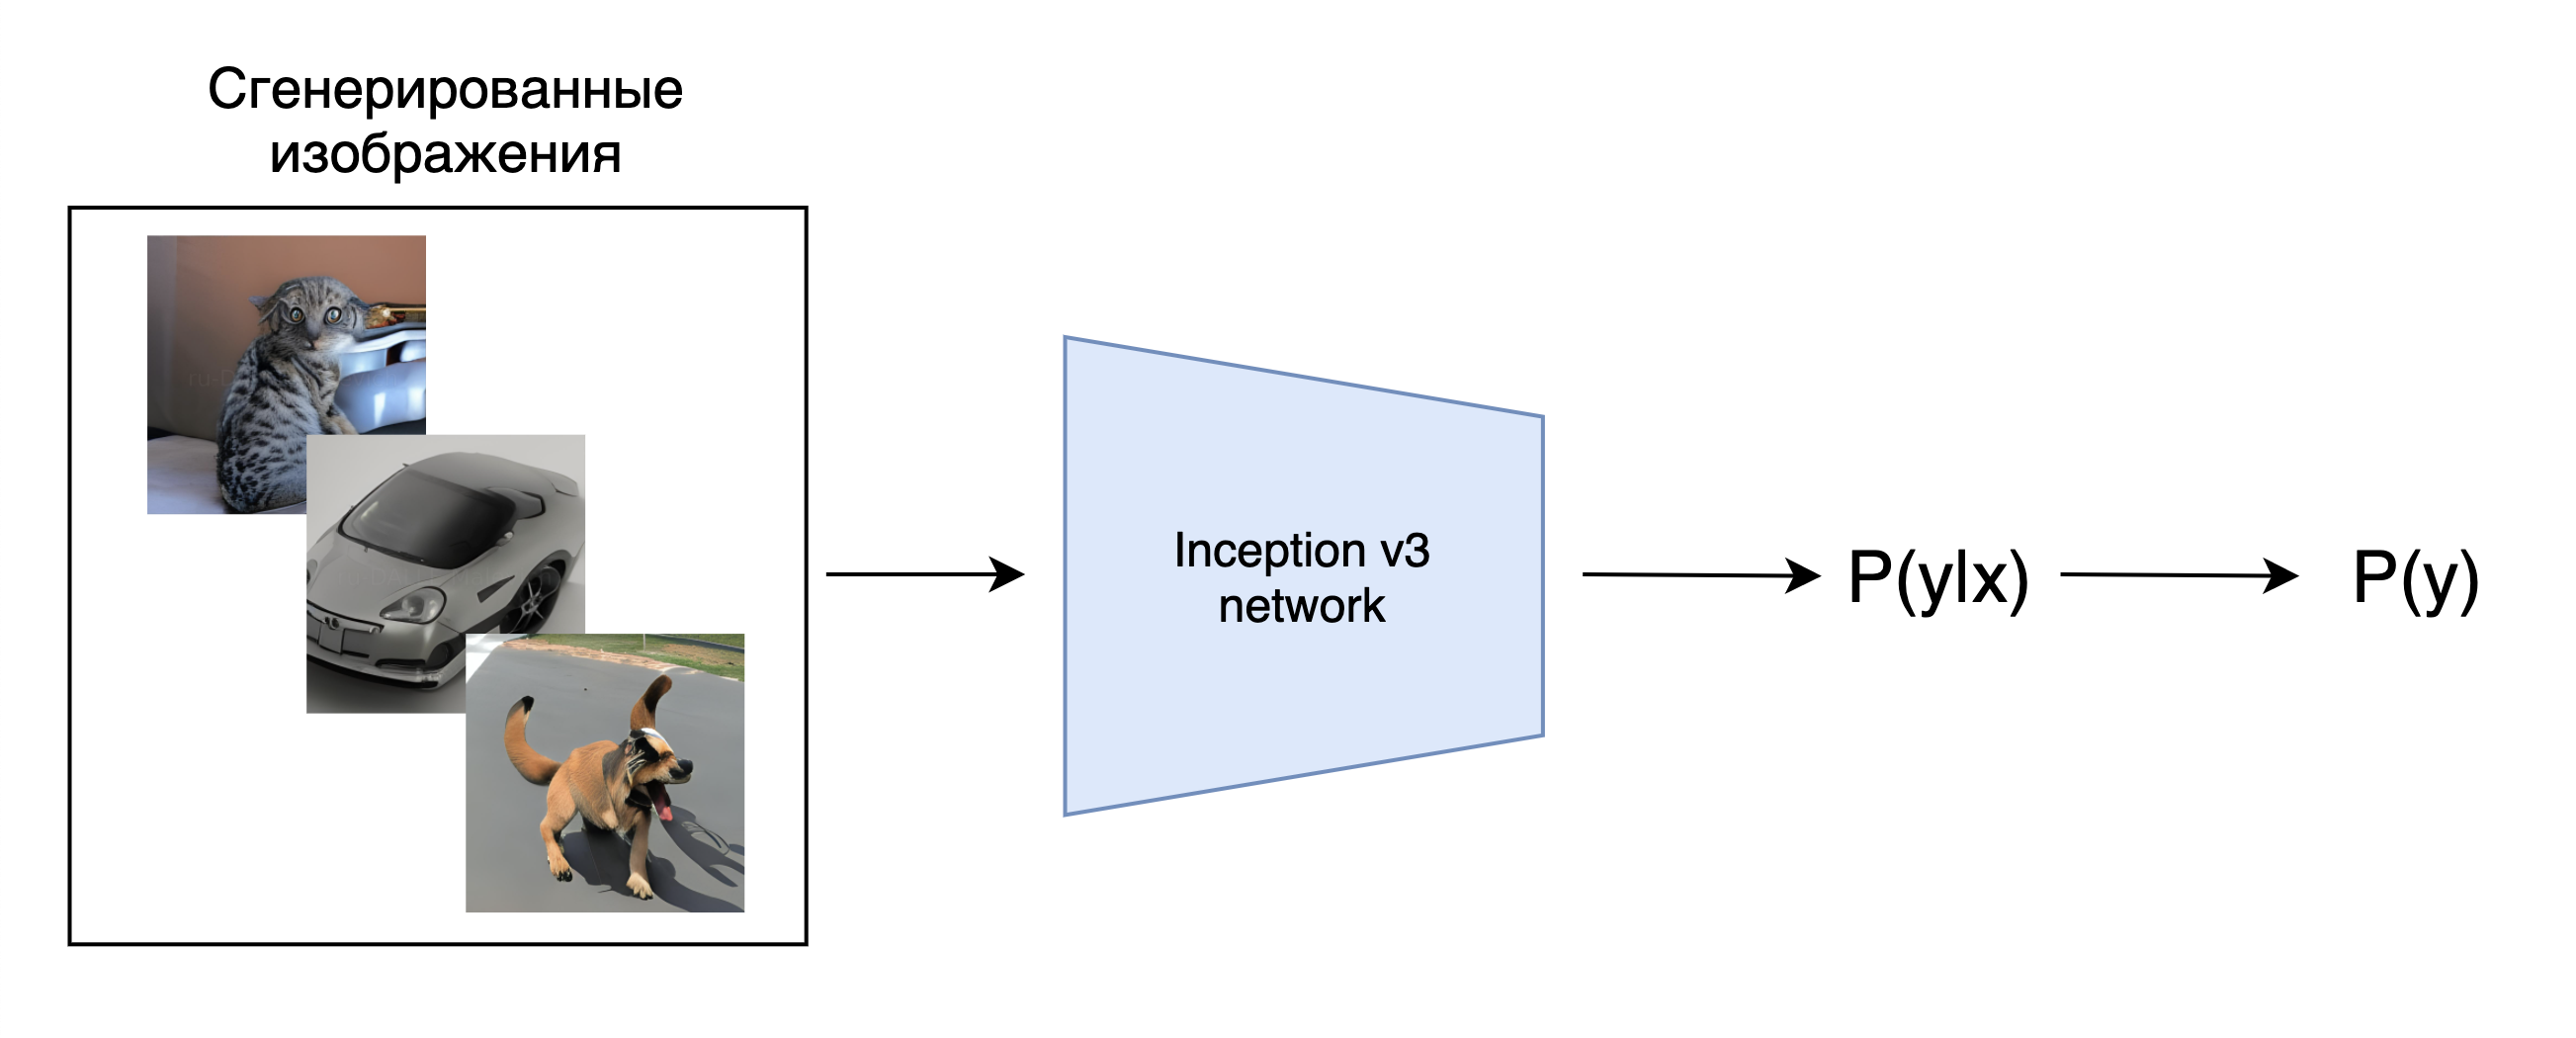

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

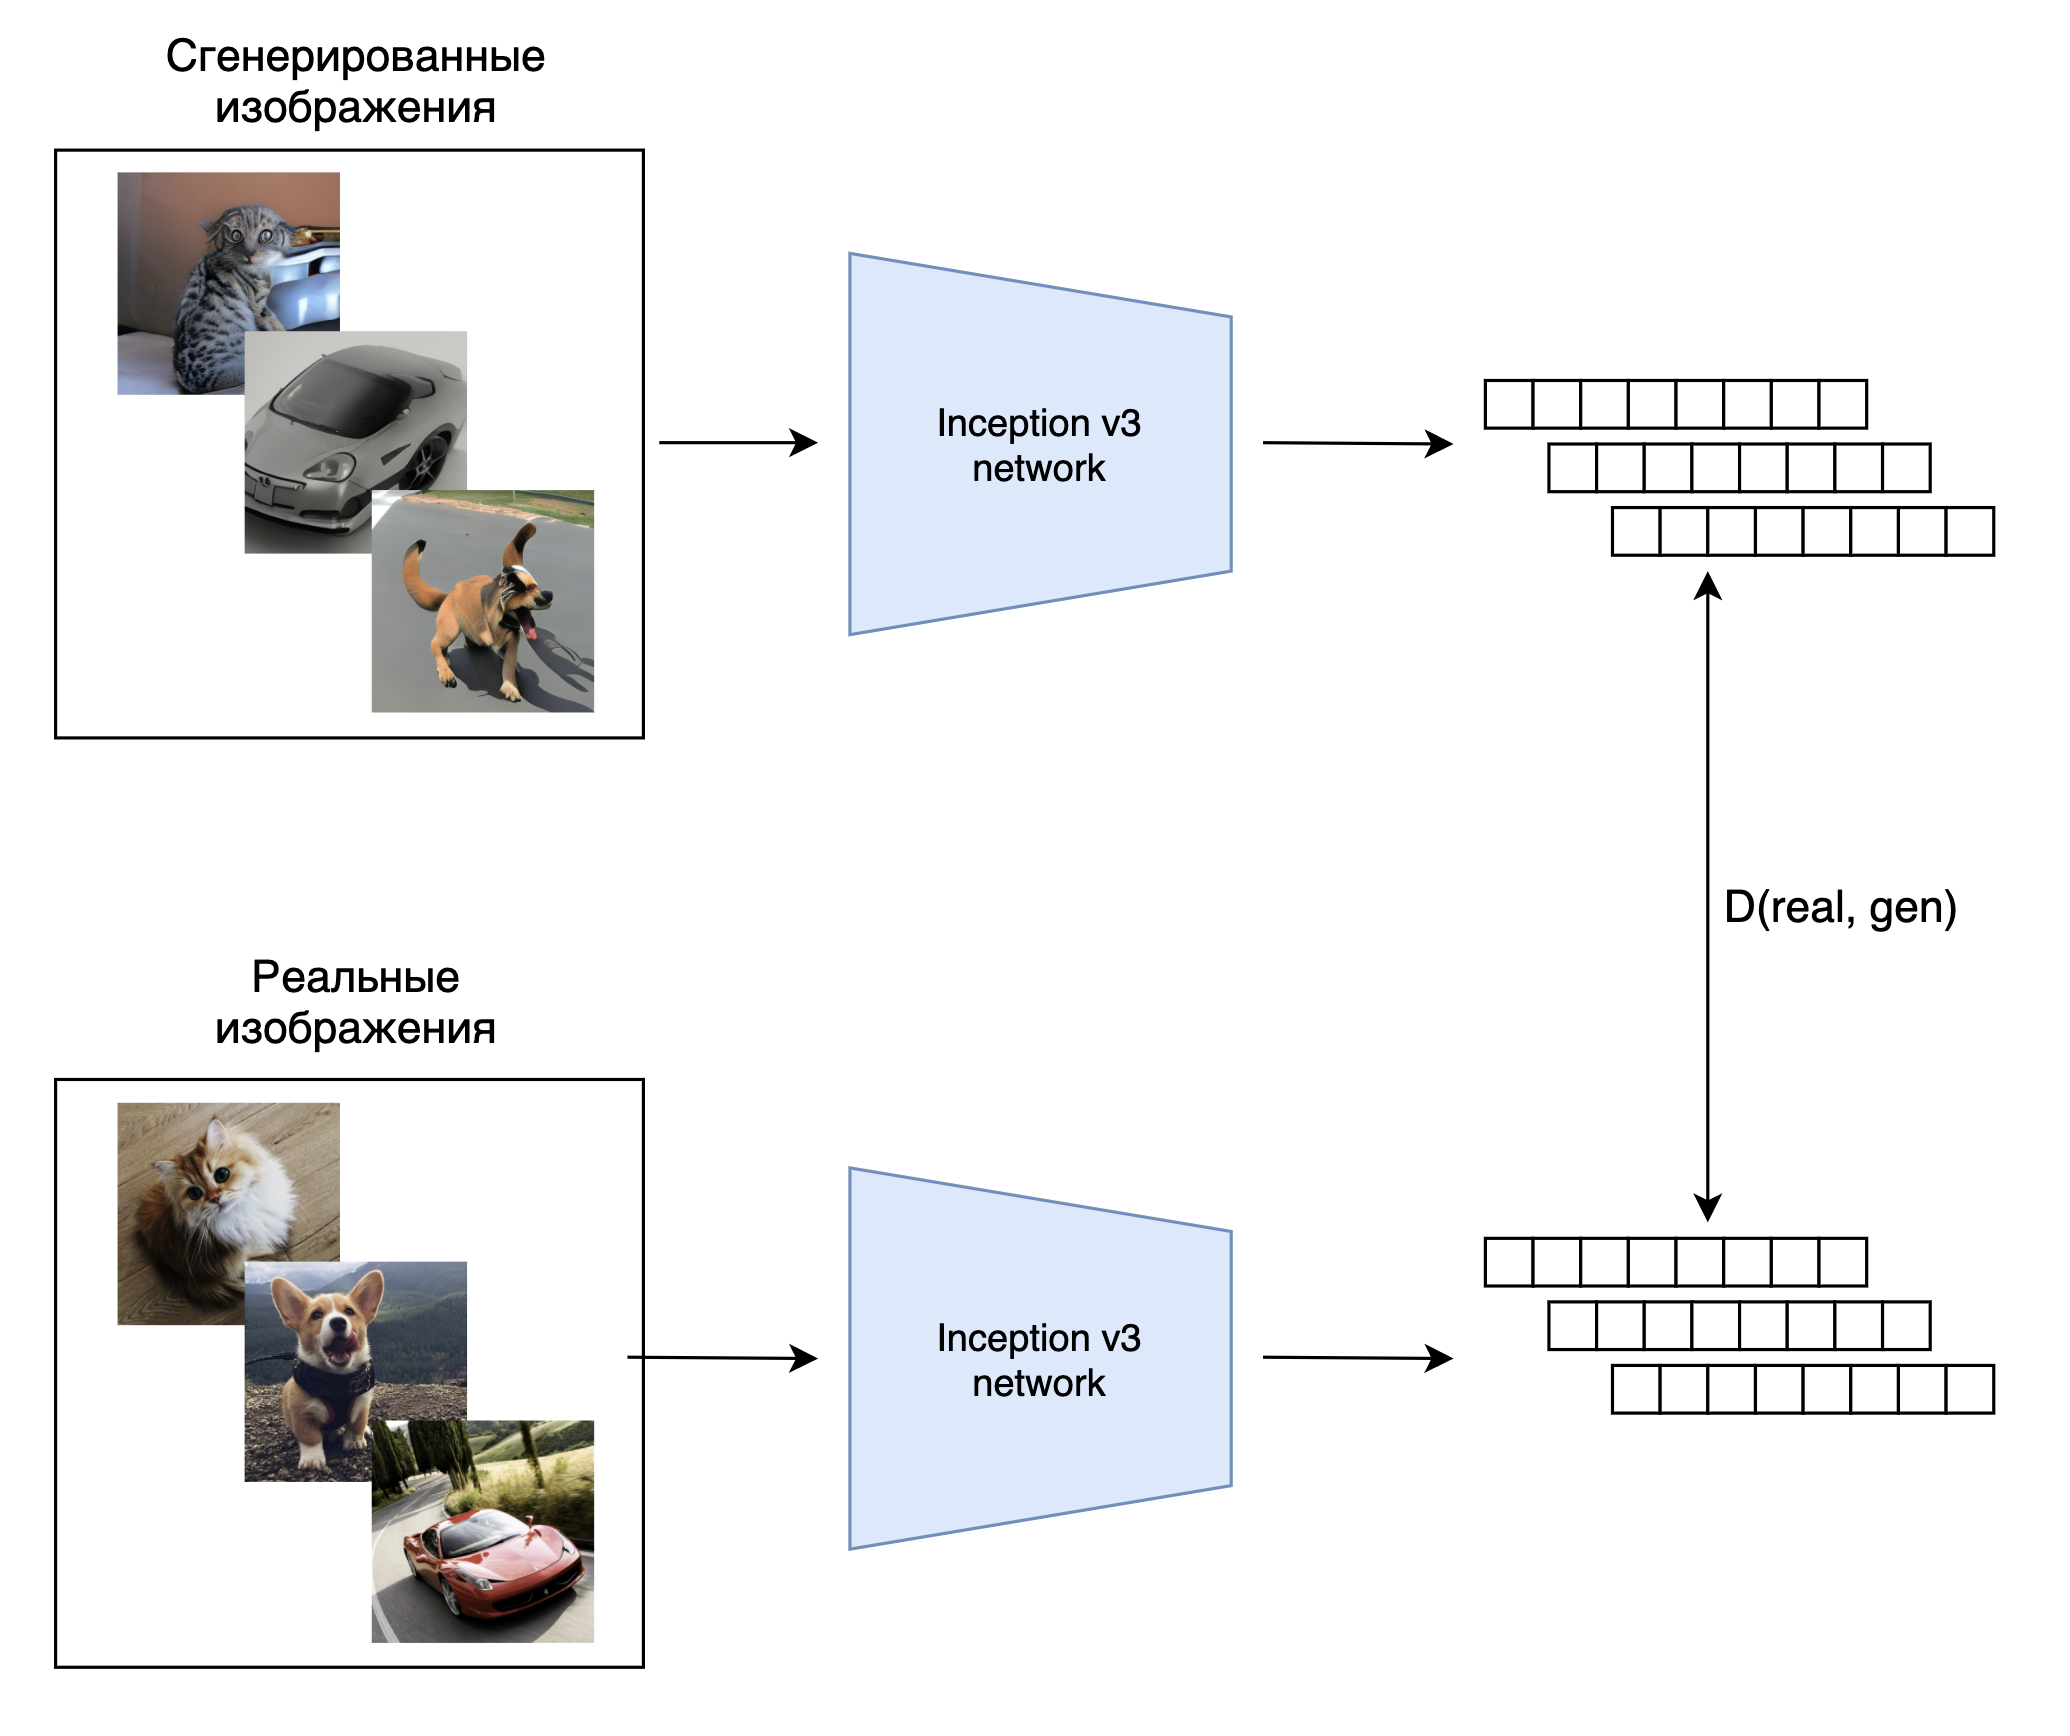

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN на датасете CIFAR10, используя методы регуляризации: label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей без регуляризаций и с различными их комбинациями (хотя бы одной). Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | |
Label Smoothing (LS) |  |
Spectral Normalization (SN) |  |
DCGAN + LS + SN | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [105]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

In [106]:
cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  4


(array([  13.,   48.,  406., 1048.,  874., 1419., 1658., 1769., 1851.,
        1198.,  947.,  589.,  267.,  153.,   48.]),
 array([-0.81176472, -0.75843138, -0.70509803, -0.65176469, -0.59843141,
        -0.54509807, -0.49176472, -0.43843138, -0.38509804, -0.3317647 ,
        -0.27843139, -0.22509804, -0.1717647 , -0.11843137, -0.06509804,
        -0.01176471]),
 <BarContainer object of 15 artists>)

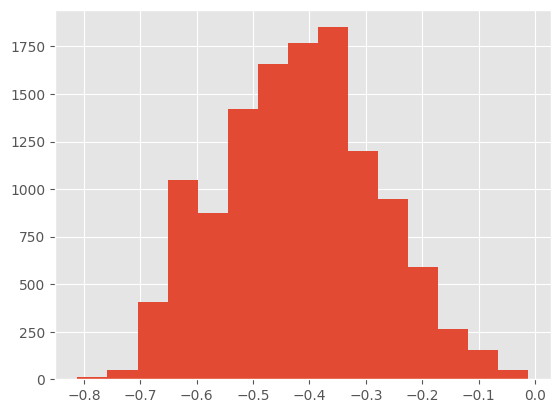

In [107]:
img, label = cifar_dataset[10]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

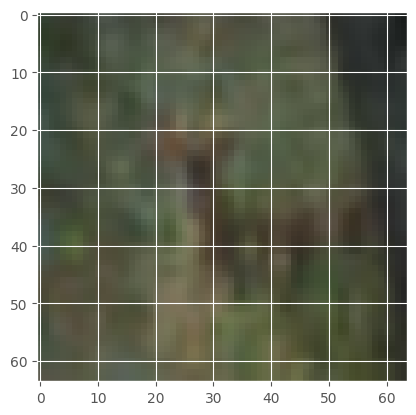

In [108]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    return (img + 1) / 2

# show  image sample with matplotlib
imgplot = plt.imshow(denorm(img.permute(1, 2, 0)))

In [109]:
# define the dataloader
from torch.utils.data import DataLoader

dataloader = DataLoader(cifar_dataset, batch_size=CFG.batch_size, shuffle=True)
# for i, (images, _) in enumerate(dataloader):
#   print(i, images.shape)
#   imgplot = plt.imshow(denorm(images.permute(1, 2, 0)))

# Спектральная нормализация

In [6]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [273]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Second ConvTranspose2d: from ngf*8 to ngf*4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Third ConvTranspose2d: from ngf*4 to ngf*2
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Fourth ConvTranspose2d: from ngf*2 to ngf
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Final ConvTranspose2d: from ngf to nc (output channels)
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = input.view(input.shape[0], input.shape[1], 1, 1)
        x = self.sequential(x)
        return x

# Discriminator

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.sequential = nn.Sequential(
            # Первый слой: от (nc, 64, 64) до (ndf, 32, 32), без BatchNorm и Dropout
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Второй слой: от (ndf, 32, 32) до (ndf*2, 16, 16) с BatchNorm и Dropout
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Третий слой: от (ndf*2, 16, 16) до (ndf*4, 8, 8) с BatchNorm и Dropout
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Четвертый слой: от (ndf*4, 8, 8) до (ndf*8, 4, 4) с BatchNorm и Dropout
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Пятый слой: от (ndf*8, 4, 4) до (1, 1, 1) с Sigmoid для классификации
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x.view(x.size(0), -1)

In [274]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf)

torch.Size([2, 3, 64, 64])


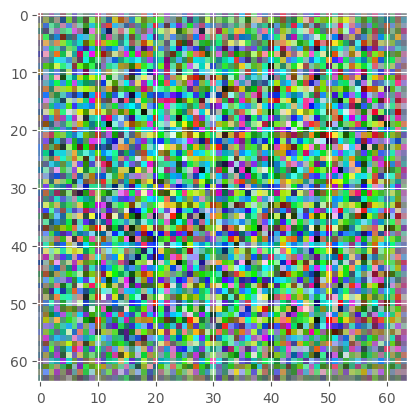

In [275]:
# show the output of model
y = G(torch.randn(2, CFG.nz))
print(y.shape)
single_image = denorm(y[0]).detach().numpy().transpose(1, 2, 0)

plt.imshow(single_image)

In [264]:
# feel free to reuse your training functions

Discriminator Training

In [265]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [276]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator

optimizer_G = torch.optim.Adam(G.parameters(), lr=CFG.lr*1.5)
optimizer_D = torch.optim.Adam(D.parameters(), lr=CFG.lr*0.5)

In [277]:

def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()


LABEL_SMOOTH = 0.8
def train_discriminator(images):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)*LABEL_SMOOTH
    fake_labels = torch.ones(batch_size, 1).to(device)*(1 - LABEL_SMOOTH)

    outputs = D(images)

    # Loss for real images
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    loss.backward()
    optimizer_D.step()
    # Adjust the parameters using backprop

    return loss, real_score, fake_score

Generator Training

In [268]:
#Add gauss noise
# noise = 0.005*np.random.uniform()*np.amax(sound)

In [278]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (CFG.batch_size, CFG.nz))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    # Reset gradients
    reset_grad()
    # Backprop and optimize
    g_loss.backward()
    optimizer_G.step()
    return g_loss, fake_images

## Start the training process

In [279]:
sample_dir = "images"
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (CFG.batch_size, CFG.nz))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=3d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [280]:
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(dataloader)
# G.load_state_dict(torch.load('/content/generator_v4.pth'))
# D.load_state_dict(torch.load('/content/discriminator_v4.pth'))
G.to(device)
D.to(device)

d_losses, g_losses, real_scores, fake_scores = [], [], [], []

In [282]:
import torch

def save_checkpoint(epoch, G, D, optimizer_G, optimizer_D, d_losses, g_losses, real_scores, fake_scores):
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict(),
        'G_optimizer_state_dict': optimizer_G.state_dict(),
        'D_optimizer_state_dict': optimizer_D.state_dict(),
        'd_losses': d_losses,
        'g_losses': g_losses,
        'real_scores': real_scores,
        'fake_scores': fake_scores
    }
    torch.save(checkpoint, 'checkpoint.pth')
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(checkpoint_path, G, D, optimizer_G, optimizer_D):
    checkpoint = torch.load(checkpoint_path)
    epoch = checkpoint['epoch']
    G.load_state_dict(checkpoint['generator_state_dict'])
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['G_optimizer_state_dict'])
    optimizer_D.load_state_dict(checkpoint['D_optimizer_state_dict'])
    d_losses = checkpoint['d_losses']
    g_losses = checkpoint['g_losses']
    real_scores = checkpoint['real_scores']
    fake_scores = checkpoint['fake_scores']
    print(f"Checkpoint loaded from epoch {epoch}.")
    return epoch, d_losses, g_losses, real_scores, fake_scores

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%time
start_epoch = 0

# If a checkpoint exists, load it and resume training
try:
    start_epoch, d_losses, g_losses, real_scores, fake_scores = load_checkpoint('checkpoint.pth', G, D, optimizer_G, optimizer_D)
except FileNotFoundError:
    print("No checkpoint found, starting training from scratch.")

for epoch in range(start_epoch, num_epochs):
    for i, (images, _) in enumerate(dataloader):
        if i == 390:
            break
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1)
        images = images.view(CFG.batch_size, CFG.nc, CFG.image_size, CFG.image_size).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i + 1) % 130 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Sample and save images
    save_fake_images(epoch+1)

    # Save models and checkpoint
    torch.save(G.state_dict(), 'generator_v4.pth')
    torch.save(D.state_dict(), 'discriminator_v4.pth')
    save_checkpoint(epoch + 1, G, D, optimizer_G, optimizer_D, d_losses, g_losses, real_scores, fake_scores)


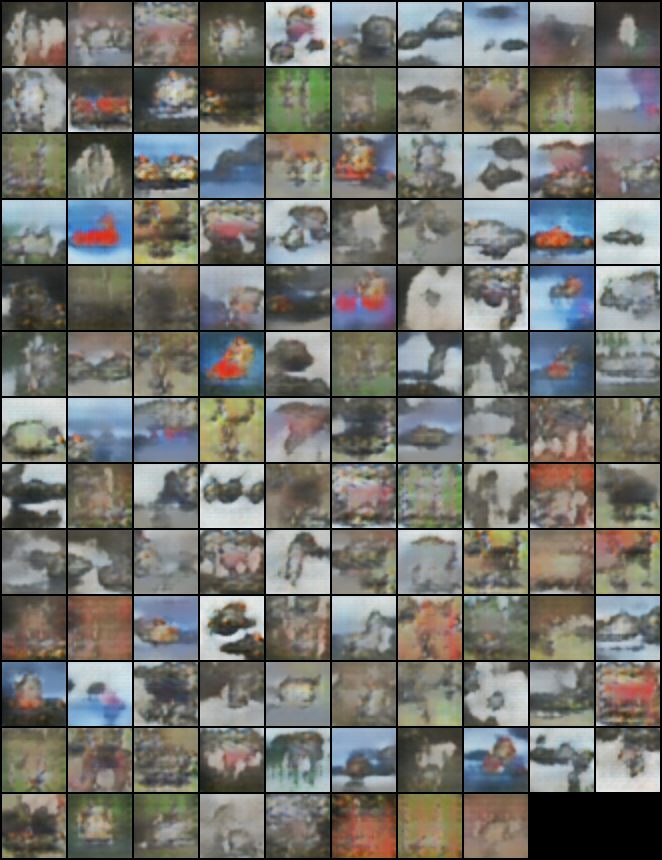

In [ ]:
Image(os.path.join(sample_dir, 'fake_images-053.png'))

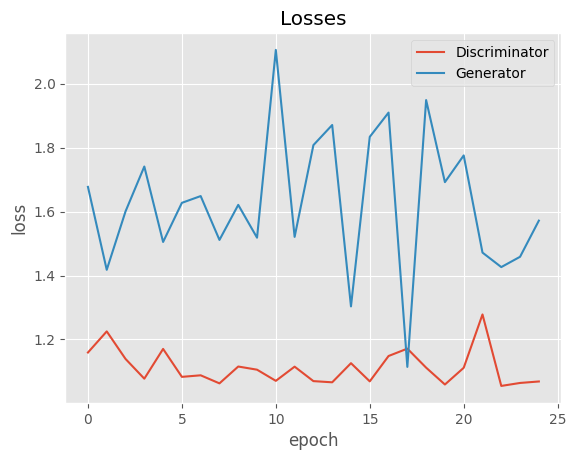

In [65]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

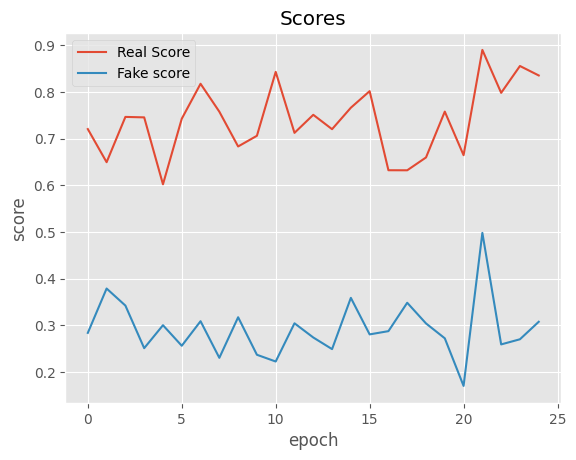

In [66]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

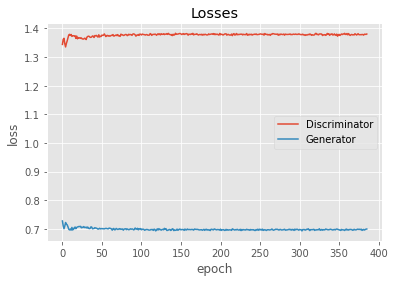

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

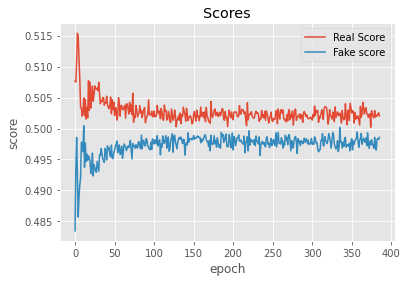

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [ ]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git

Cloning into 'pytorch-gan-metrics'...


In [ ]:
%pip install pytorch-gan-metrics

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
%cd pytorch-gan-metrics
#### Prepare Statistics for FID


/home/jupyter/work/resources/Generative-Models-2024/Assignment 2/pytorch-gan-metrics


In [ ]:
# import pytorch_gan_metrics
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim

    def __len__(self):
        return 500

    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

# define dataset
#create dataloader
G_eval = Genearator(CFG.nc, CFG.nz, CFG.ngf)
G_eval.load_state_dict(torch.load('generator_v2.pth', map_location=CFG.device))

dataset = GeneratorDataset(G_eval, CFG.nz)
G_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Inception Score
IS, _ = get_inception_score(G_dataloader)
print(f"Inception Score: {IS}")


# Frechet Inception Distance
FID = get_fid(G_dataloader)
print(f"FID: {FID}")
# Inception Score + Frechet Inception Distance
(IS, IS_std), FID = get_inception_score_and_fid(G_dataloader)
print(f"Inception Score: {IS}, FID: {FID}")


ModuleNotFoundError: No module named 'pytorch_gan_metrics'